# Preamble

In [1]:
%matplotlib inline

In [2]:
! pip install imageio

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import operator
import collections

import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as animation
from matplotlib.transforms import ScaledTranslation

import numpy as np
import imageio
from tqdm import tqdm

In [5]:
def rotate_point(x, y, angle_deg):
    cos,sin = np.cos(angle_deg*np.pi/180),np.sin(angle_deg*np.pi/180)
    return cos*x-sin*y,sin*x+cos*y

def draw_brace(ax, span, position, text, text_pos, brace_scale=1.0, beta_scale=300., rotate=False,
               rotate_text=False, color='black', fontsize=16, linewidth=1.):
    '''
        all positions and sizes are in axes units
        span: size of the curl
        position: placement of the tip of the curl
        text: label to place somewhere
        text_pos: position for the label
        beta_scale: scaling for the curl, higher makes a smaller radius
        rotate: anngle of rotation for the curl
        rotate_text: angle of rotation for the text
    '''
    # get the total width to help scale the figure
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin
    resolution = int(span/xax_span*100)*2+1 # guaranteed uneven
    beta = beta_scale/xax_span # the higher this is, the smaller the radius
    # center the shape at (0, 0)
    x = np.linspace(-span/2., span/2., resolution)
    # calculate the shape
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    # put the tip of the curl at (0, 0)
    max_y = np.max(y)
    min_y = np.min(y)
    y /= (max_y-min_y)
    y *= brace_scale
    y -= max_y
    # rotate the trace before shifting
    x,y = rotate_point(x, y, rotate)
    # shift to the user's spot
    x += position[0]
    y += position[1]
    ax.autoscale(False)
    ax.plot(x, y, clip_on=False, color=color, lw=linewidth)
    # put the text
    ax.text(text_pos[0], text_pos[1], text, ha='center', va='bottom', rotation=rotate_text, color=color, fontsize=fontsize)

In [6]:
def draw_unfinished_brace(ax, span, position, text, text_pos, brace_scale=1.0, beta_scale=300., rotate=False,
               rotate_text=False, color='black', fontsize=16, linewidth=1., extra_dash=0.1):
    '''
        all positions and sizes are in axes units
        span: size of the curl
        position: placement of the tip of the curl
        text: label to place somewhere
        text_pos: position for the label
        beta_scale: scaling for the curl, higher makes a smaller radius
        rotate: anngle of rotation for the curl
        rotate_text: angle of rotation for the text
    '''
    # get the total width to help scale the figure
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin
    resolution = int(span/xax_span*100)*2+1 # guaranteed uneven
    beta = beta_scale/xax_span # the higher this is, the smaller the radius
    # center the shape at (0, 0)
    x = np.linspace(-span/2., span/2., resolution)
    x_extended = np.linspace(-span*(0.5+extra_dash), span*0.5, (int)((1+extra_dash)*resolution))
    # calculate the shape
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    remove = int(0.2*len(x))
    y_extended = np.concatenate((y_half_brace[remove:], y_half_brace[-2::-1]))
    extra_length = len(x_extended)-len(y_extended)
    y_extended = np.concatenate((y_extended[0]*np.ones(extra_length), y_extended))
    # put the tip of the curl at (0, 0)
    max_y = np.max(y_extended)
    min_y = np.min(y_extended)
    y_extended /= (max_y-min_y)
    y_extended *= brace_scale
    y_extended -= max_y
    # rotate the trace before shifting
    x_extended,y_extended = rotate_point(x_extended, y_extended, rotate)
    # shift to the user's spot
    x_extended += position[0]
    y_extended += position[1]
    ax.autoscale(False)
    dashed_length = len(x_extended)-resolution
    ax.plot(x_extended[dashed_length:], y_extended[dashed_length:], clip_on=False, color=color, lw=linewidth)
    ax.plot(x_extended[:dashed_length], y_extended[:dashed_length], clip_on=False, color=color, lw=linewidth, linestyle=(0, (5, 5)))
    # put the text
    ax.text(text_pos[0], text_pos[1], text, ha='center', va='bottom', rotation=rotate_text, color=color, fontsize=fontsize)

# Network architecture

In [7]:
class Net(torch.nn.Module):
    """
    1 hidden layer Relu network architecture
    """
    def __init__(self, n_hidden, n_feature=1, n_output=1, bias_hidden=True, skip_connection=True, **kwargs):
        """
        n_hidden: number of hidden neurons
        n_feature: dimension of input
        n_output: dimension of output
        bias_hidden: if True, use bias parameters in hidden layer. Use no bias otherwise
        skip_connection: if True, add a (free) affine term in the represented function
        """
        super(Net, self).__init__()
        self.bias_hidden_ = bias_hidden

        self.skip_ = skip_connection

        self.hidden = torch.nn.Linear(n_feature, n_hidden, bias=bias_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output, bias=False)   # output layer
        self.activation = kwargs.get('activation', torch.nn.ReLU()) # activation of hidden layer
        if self.skip_:
            self.skip = torch.nn.Linear(n_feature, n_output, bias=True)   # affine term

    def forward(self, z):
        z1 = self.activation(self.hidden(z))
        z1 = self.predict(z1)
        if self.skip_:
            z1 += self.skip(z)
        return z1

    def weight_norm(self, bias=True):
        """
        Return the total squared L2 norm of the parameters
        bias: if True, count the bias weight in the L2 norm
        """
        if bias:
            sq_hidden_norms = (self.hidden.weight.data.norm(dim=1).square()+self.hidden.bias.data.square()).sum()
        else:
            sq_hidden_norms = self.hidden.weight.data.norm(dim=1).square().sum()
        sq_output_norms = self.predict.weight.data.square().sum()
        return (sq_hidden_norms+sq_output_norms)/2

    def balance(self, bias=True):
        """
        make the weights of the hidden and output layer balanced (useful to minimise the L2 norm of the parameters)
        bias: if True, count the bias weight in the L2 norm
        """
        if bias:
            hidden_norms = (self.hidden.weight.data.norm(dim=1).square()+self.hidden.bias.data.square()).sqrt().reshape(1,-1)
        else:
            hidden_norms = (self.hidden.weight.data.norm(dim=1).square()).sqrt().reshape(1,-1)
        output_norms = self.predict.weight.data.abs()

        #avoid division by 0
        hidden_norms[hidden_norms==0] = 1
        output_norms[output_norms==0] = 1

        c = (output_norms/hidden_norms).sqrt()
        self.hidden.weight.data *= c.T
        if self.bias_hidden_:
            self.hidden.bias.data *= c.reshape(-1)
        self.predict.weight.data /= c.reshape(-1)

# Generating data

In [8]:
def generate_convex_sequence(npoints, x0=None, delta0=None, xmaxdiff=1, deltamaxdiff=1, xmindiff=0, deltamindiff=0):
    """
    return a sequence of points (x_i, delta_i) such that the piecewise linear interpolation
    is convex on the whole interval (x_min, x_max).
    The delta_i give the slope of the piecewise linear interpolation on the interval (x_i, x_{i+1})
    It does so by generating increments of x and delta as unfiorm random variables.
    xmaxdiff: max range of x increments
    xmindiff: min range of x increments
    x0: fix first value of x. If None, choose one uniformly at random in (-1,1)
    deltamaxdiff: max range of delta increments
    deltamindiff: min range of delta increments
    delta0: fix first value of delta. If None, choose one uniformly at random in (-1,1)
    """

    if x0 is None:
        x0 = np.random.uniform(low=-1,high=1)
    x = x0*np.ones(npoints)
    xincr = np.random.uniform(low=xmindiff, high=xmaxdiff, size=npoints-1)
    x[1:]+=xincr.cumsum()


    if delta0 is None:
        delta0 = np.random.uniform(low=-1,high=1)
    delta = delta0*np.ones(npoints-1)
    deltaincr = np.random.uniform(low=deltamindiff, high=deltamaxdiff, size=npoints-2)
    delta[1:]+=deltaincr.cumsum()

    return x,delta

def deltas_to_ys(x,delta,y0=0):
    """
    return a sequence of points y_i such that the sequence (coordinates,values) = (x,y)
    corresponds to the sequence (coordinate, slope) = (x, delta).
    y0: value of the first y.
    """
    y = y0*np.ones(len(x))
    yincr = delta*(x[1:]-x[:-1])
    y[1:] += np.cumsum(yincr)
    return y

# Solving min norm interpolator

In [9]:
def g(x1,x0,delta):
    return lambda s1,s0 : np.sqrt((x1*(s1.reshape(-1,1)-delta)-x0*(s0.reshape(1,-1)-delta))**2+(s1.reshape(-1,1)-s0.reshape(1,-1))**2)

In [10]:
def min_norm_interpolator(x, delta, grid_size=10^10, return_cost=False):
    """
    Given the (coordinates, slopes) sequence (x,delta), return the sequence of slope (s_i) minimising the dynamic program.
    Since the dynamic program is continuous, we approximate it by discretising the intervals (delta_i,delta_{i+1})
    grid_size: number of points in the discretisation of (delta_i,delta_{i+1}) at each iteration
    return_cost: if True, also return the approximations of c_i as a matrix as well as the total cost of the associated interpolator
    """
    n = len(x)
    i0 = np.searchsorted(x, 0, side='right', sorter=None)
    cost = np.zeros((n, grid_size))

    slope = np.zeros((n, grid_size), dtype=int) # argmin associated to the costs c_i

    grid = np.zeros((n, grid_size))
    grid[0,:] = delta[0]
    grid[-1,:] = delta[-1]

    for i in range(1,n-1):
        if (i>=2) and (np.sign(delta[i]-delta[i-1])*np.sign(delta[i-2]-delta[i-1])>=0):
            grid[i,:] = delta[i-1]
        else:
            grid[i,:] = np.linspace(delta[i-1],delta[i],grid_size)

    for i in range(0,i0-1):
        #compute c^-_{i+1}
        s0 = grid[i,:]
        s1 = grid[i+1,:]
        g1 = g(x[i+1],x[i],delta[i])
        cost[i+1,:] = np.min(g1(s1,s0)+cost[i,:].reshape(1,-1),axis=1)
        slope[i+1,:] = np.argmin(g1(s1,s0)+cost[i,:].reshape(1,-1),axis=1)

        # handle the case s_i = delta_i
        k1 = np.min((np.searchsorted(grid[i,:],delta[i]),grid_size-1))
        k2 = np.min((np.searchsorted(grid[i+1,:],delta[i]),grid_size-1))
        cost[i+1,k2] = cost[i,k1]
        slope[i+1,k2] = k1

    for j in range(1,n-i0):
        # compute c^+_i
        i = n-j-1
        s0 = grid[i,:]
        s1 = grid[i+1,:]
        g1 = g(x[i+1],x[i],delta[i])
        cost[i,:] = np.min(g1(s1,s0)+cost[i+1,:].reshape(-1,1),axis=0)
        slope[i,:] = np.argmin(g1(s1,s0)+cost[i+1,:].reshape(-1,1),axis=0)

        # handle the case s_i = delta_i
        k1 = np.min((np.searchsorted(grid[i,:],delta[i]),grid_size-1))
        k2 = np.min((np.searchsorted(grid[i+1,:],delta[i]),grid_size-1))
        cost[i,k1] = cost[i+1,k2]
        slope[i,k1] = k2

    s_index = np.zeros(n, dtype=int) # minimal sequence of slopes as indices

    #compute optimal slopes at x_{i0-1} and x_{i0}
    if (i0>0 and i0<n):
        i = i0-1
        s0 = grid[i,:]
        s1 = grid[i+1,:]
        g1 = g(x[i+1],x[i],delta[i])
        Z = g1(s1,s0)+cost[i+1,:].reshape(-1,1)+cost[i,:].reshape(1,-1)
        c = np.min(Z)
        k1,k0 = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
        s_index[i0] = k1
        s_index[i0-1] = k0
    elif i0==0:
        s_index[i0]=0
        c = np.min(cost[0,:])
    else: #i0==n
        s_index[i0-1]=0
        c = np.min(cost[i0-1,:])

    for j in range(1,i0):
        i=i0-j-1
        s_index[i]=slope[i+1,s_index[i+1]]
    for i in range(i0,n-1):
        s_index[i+1]=slope[i,s_index[i]]

    s = np.zeros(n) # minimal sequence of slopes
    for i in range(0,n):
        s[i] = grid[i,s_index[i]]

    if return_cost:
        return s,cost,c
    else:
        return s

In [11]:
def slopes_to_network(x, y, s, balanced=True):
    """
    From an appropriate sequence of slopes s, return a corresponding neural network
    interpolating the data (x,y).
    We use for this the mapping given in the Appendix.
    balanced: if True, return a balanced network
    """
    n = len(x)
    net = Net(n-1)
    for w in net.parameters(): # set all weights to 0
        torch.nn.init.zeros_(w.data)

    # affine term
    net.skip.weight.data[0,0] = s[0]
    net.skip.bias.data[0]=y[0]-s[0]*x[0]

    #ReLU terms
    torch.nn.init.ones_(net.hidden.weight.data)
    for i in range(0,n-1):
        # a_i
        net.predict.weight.data[0,i] = s[i+1]-s[i]
        # tau_i
        if (s[i+1]!=s[i]):
            net.hidden.bias.data[i] = -x[i+1]+(y[i+1]-y[i]-s[i]*(x[i+1]-x[i]))/(s[i+1]-s[i])
        else:
            net.hidden.weight.data[i] = 0


    if balanced:
        net.balance()

    return net

Different Risk Measures Comparison

In the below, we measure the L1 and L3 risk over 100 trials of random sapling of 2000 points and measure the L1, L2, L3 and L_infty losses

In [12]:
np.random.seed(1)
xtest=np.random.rand(10000)
ztest = torch.Tensor(xtest).reshape(-1,1)

In [13]:
np.random.seed(3)
n=2000
N=100
xtest=np.random.rand(10000)
ztest = torch.Tensor(xtest).reshape(-1,1)
#y=net1(z).data.numpy()

L1risk=np.zeros(N)
L2risk=np.zeros(N)
L3risk=np.zeros(N)
Linfty=np.zeros(N)
for j in range(0,N):
  xten=np.random.rand(n)
  xten=np.sort(xten)
  yten=np.random.uniform(-2,2,n)
  deltaten=np.zeros(n-1)
  for i in range(0,n-1):
    deltaten[i]=(yten[i+1]-yten[i])/(xten[i+1]-xten[i])

  sten,cost,c = min_norm_interpolator(xten,deltaten,return_cost=True, grid_size=300)
  #print(s)
  netten = slopes_to_network(xten, yten, sten, balanced=False)
  ytest=netten(ztest).detach().numpy()
  ytest=np.absolute(ytest)
  L1risk[j] = np.sum(ytest, dtype=np.float64)/10000
  sumsquare=np.sum(np.square(ytest),dtype=np.float64)/10000
  L2risk[j]=sumsquare**0.5
  sumcube=np.sum(np.power(ytest,3),dtype=np.float64)/10000
  L3risk[j]=sumcube**0.33
  Linfty[j]=np.max(ytest)


In [14]:
L1risk=np.sort(L1risk)
L2risk=np.sort(L2risk)
L3risk=np.sort(L3risk)
Linfty=np.sort(Linfty)

In [15]:
print(f'L1 risk={np.sum(L1risk)/100}')
print(f'L2 risk={np.sum(L2risk)/100}')
print(f'L3 risk={np.sum(L3risk)/100}')
print(f'Linf risk={np.sum(Linfty)/100}')

L1 risk=1.6155532569422684
L2 risk=3.244514823879848
L3 risk=6.3596295141779855
Linf risk=69.4132586479187


The following code generates 30 random points from a certain groud-truth function and compares min-norm interpolator and linear splies

In [16]:
np.random.seed(0)
n_list = [3, 2, 3, 3]
sign_list = [1, 0, 1, -1]
xminincr,xmaxincr = 0.2,1
dminincr,dmaxincr = 0.5,1
last_n = 0
delta0 = -2
x0 = -4

n_points = np.sum(n_list)
x = np.zeros(n_points)
delta = np.zeros(n_points-1)

for i in range(len(n_list)):
    incr = n_list[i]
    n = incr + last_n
    s = sign_list[i]
    if s==1:
        (x_n,delta_n) = generate_convex_sequence(incr+2,xmindiff=xminincr,xmaxdiff=xmaxincr,x0=x0,deltamindiff=dminincr,deltamaxdiff=dmaxincr,delta0=delta0)
    elif s==-1:
        (x_n,delta_n) = generate_convex_sequence(incr+2,xmindiff=xminincr,xmaxdiff=xmaxincr,x0=x0,deltamindiff=-dmaxincr,deltamaxdiff=-dminincr,delta0=delta0)
    elif s==0:
        (x_n,delta_n) = generate_convex_sequence(incr+2,xmindiff=xminincr,xmaxdiff=xmaxincr,x0=x0,deltamindiff=0,deltamaxdiff=0,delta0=delta0)
    x[last_n:n] = x_n[1:-1]
    if n==n_points:
        delta[last_n:n-1] = delta_n[1:-1]
    else:
        delta[last_n:n] = delta_n[1:]
    x0 = x_n[-2]
    delta0 = delta_n[-1]
    last_n = n

y = deltas_to_ys(x,delta)
print(delta)

[-1.2881726  -0.46522554  0.25356806  0.25356806  0.25356806  0.76367726
  1.67998718  2.56906556  1.95933015  1.01846736]


30
30


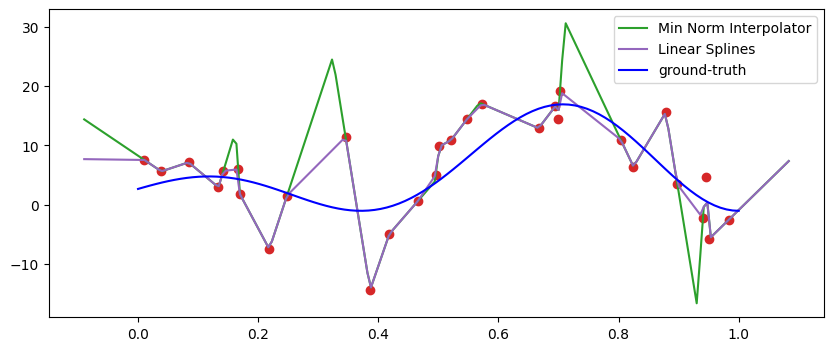

In [17]:
import math
np.random.seed(9)
n=30

def f1(x):
   return np.sin(10*x+1) + (10*x+1) + (10*x+1) * np.sin(10*x+1)

xten=np.random.rand(n)
xten=np.sort(xten)
#print(xten)
yten=np.random.normal(0,5,n)
for i in range(0,n-1):
    yten[i]=yten[i]+ f1(xten[i])
#print(yten)
deltaten=np.zeros(n-1)
for i in range(0,n-1):
    deltaten[i]=(yten[i+1]-yten[i])/(xten[i+1]-xten[i])

sten,cost,c = min_norm_interpolator(xten,deltaten,return_cost=True, grid_size=2000)
#print(s)
netten = slopes_to_network(xten, yten, sten, balanced=False)

deltanew=np.zeros(n)
for i in range(0,n):
  if i==0:
    deltanew[i]=delta[0]
  else:
    deltanew[i]=deltaten[i-1]

print(np.size(sten))
print(np.size(deltanew))
netsplines = slopes_to_network(xten, yten, deltanew, balanced=False)


z = torch.Tensor(np.linspace(xten[0]-0.1,xten[-1]+0.1,200).reshape(-1,1))
# view data
plt.figure(figsize=(10,4))
plt.scatter(xten, yten, color = "tab:red")

plt.plot(z.data.numpy(), netten(z).data.numpy(), color = "tab:green", label="Min Norm Interpolator")
plt.plot(z.data.numpy(), netsplines(z).data.numpy(), color = "tab:purple", label="Linear Splines")
xall = np.linspace(0, 1, 100)
plt.plot(xall, f1(xall), color='blue', label="ground-truth")
plt.legend()
plt.savefig('large_points.svg')
plt.show()

In [18]:
delta = np.array([10, 5.63, 3.1,  -1.07712721,  -10.2695455, -7.5455, 1.0, 10.0000])
x = np.array([0.07,0.12,0.2,0.35,0.42,0.59,0.65,0.8,0.95])
y = deltas_to_ys(x,delta)

In [19]:
s,cost,c = min_norm_interpolator(x,delta,return_cost=True, grid_size=100)
#print(s)
net = slopes_to_network(x, y, s, balanced=False)

In [20]:
deltaspline = np.array([10, 5.63, 3.1,  -1.07712721,  -10.2695455, -7.5455, 1.0, 10.00000,0])
xspline = np.array([0.07,0.12,0.2,0.35,0.42,0.59,0.65,0.8,0.95,1])
yspline = deltas_to_ys(xspline,deltaspline)
sspline=np.array([0,10, 5.63, 3.1,  -1.07712721,  -10.2695455, -7.5455, 1.0, 10.00000,0])
net_spline=slopes_to_network(xspline,yspline, sspline, balanced=False)

In [21]:
s1= [5.0, 5.0, 2.3483259, -1.07712721,  -1.07712721,  -7.2695455, -3.5455, 1.0, 10.0000,0.0]
net1=slopes_to_network(x,y, s1, balanced=False)

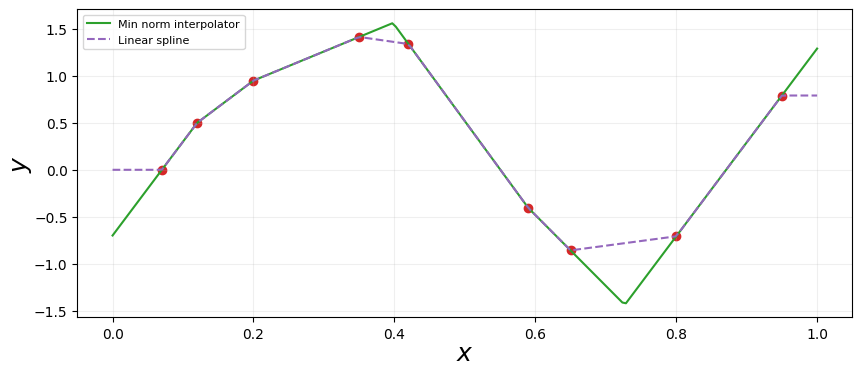

In [22]:
z = torch.Tensor(np.linspace(0,1,200).reshape(-1,1))
# view data
plt.figure(figsize=(10,4))
plt.scatter(x, y, color = "tab:red")
plt.plot(z.data.numpy(), net(z).data.numpy(), color = "tab:green", label="Min norm interpolator")
plt.plot(z.data.numpy(), net_spline(z).data.numpy(),'--' ,color = "tab:purple", label="Linear spline")
#plt.plot(z.data.numpy(), net1(z).data.numpy(),'--' ,color = "tab:red", label="Min norm (unregularized bias)")
plt.grid(alpha=0.2)
plt.xlabel(r'$x$', labelpad=0, fontsize=18)
plt.ylabel(r'$y$', labelpad=0, fontsize=18)
plt.legend(prop = {'size':8}, fontsize=18)
plt.savefig('small-example.pdf')
plt.show()

In [23]:
print("Number of kinks: " + str(np.sum(net.predict.weight.data.numpy()!=0)))

Number of kinks: 6
